check if P1 work perfectly, i mean all new node is closer and closer to 0


In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [6]:
def nc_underest(new_lb, new_ub, v_list, model_list, add_node_num=0, n_samples=5, tolerance=1e-8):
    """
    Parameters:
        delta (float): range of variable
        n_samples (float): number of sample nodes
        v_list (list): list of scenario functions  
        model: model with submodels corresponds to each scenario
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    y_nodes = np.linspace(new_lb, new_ub, n_samples).tolist()
    lst = np.ones(N).tolist()
    y_opt_list = np.ones(N).tolist() 
    as_nodes_list = np.ones(N).tolist() 
    eff_node_count = 0
    ms_list = [None] * N
    new_nodes_list = [None] * N
    add_node_eff_compare = [None] * N
    
    
    
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = tolerance
    solver.options['NonConvex'] = 2 

        
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            print('Solving scenario ',i)
            # calculate interpolation points
            as_nodes_list[i] = [v_list[i](y) for y in y_nodes]
        
            # define piecewise function for each scenario
            if hasattr(model_list[i], 'As'):
                model_list[i].del_component('As')
            if hasattr(model_list[i], 'pw'):
                model_list[i].del_component('pw')
            if hasattr(model_list[i], 'obj'):
                model_list[i].del_component('obj')
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            ms_list[i] = results.problem.lower_bound
            
            # check if new node is too close to old nodes         
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
                break
                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)

        if k < add_node_num:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            if (new_node not in y_nodes) and (k != add_node_num):
                bisect.insort(y_nodes, new_node)
                eff_node_count += 1

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = mmm-errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node

In [15]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# lower bound and upper bound
ylb = 0
yub = 0.02

# Plot the figures and error

In [22]:
# make delta list
adds = np.arange(1, 50)
results = [nc_underest(ylb,yub,v_list,[m1,m2],a) for a in adds]

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
**WARNING: Piecewise component 'pw[(Non

Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is

The new node is too close and not inserted
Adding node  15
Solving scenario  0
Solving scenario  1
Adding node  16
Solving scenario  0
Solving scenario  1
Adding node  17
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  18
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving s

Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  15
Solving scenario  0
Solving scenario  1
Adding node  16
Solvi

Solving scenario  1
The new node is too close and not inserted
Adding node  26
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' has detected slopes of consecutive piecewise segments to be within 1e-08 of one another. Refer to the Piecewise help documentation for information on how to disable this warning.
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is

Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  15
Solving scenario  0
Solving scenario  1
Adding node  16
Solving scenario  0
Solving scenario  1
Adding node  17
Solv

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  13
Solving scenario  0
Solving scenario  1
Addin

Solving scenario  1
The new node is too close and not inserted
Adding node  27
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  28
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  29
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  30
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  31
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  32
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  33
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  34
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  35
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
**WARNING: Piecewise component 'pw[(None,)]' h

The new node is too close and not inserted
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
Adding node  8
Solving scenario  0
Solving scenario  1
Adding node  9
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  10
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  11
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  12
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  13
Solving scenario  0
Solving scenario  1
Adding node  14
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  15
Solving scenario  0
Solving scenario  1
Adding node  16
Solving scenario  0
Solving scenario  1
Adding node  17
Solving scenario  0
Solving scenario  1
The new node is too

Solving scenario  1
The new node is too close and not inserted
Adding node  19
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  20
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  21
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  22
Solving scenario  0
Solving scenario  1
Adding node  23
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  24
Solving scenario  0
Solving scenario  1
Adding node  25
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  26
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  27
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  28
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  29
Solving scenario 

Solving scenario  1
The new node is too close and not inserted
Adding node  27
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  28
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  29
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  30
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  31
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  32
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  33
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  34
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  35
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  36
Solving scenario  0
Solving sc

Solving scenario  1
The new node is too close and not inserted
Adding node  30
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  31
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  32
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  33
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  34
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  35
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  36
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  37
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  38
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  39
Solving scenario  0
Solving sc

Solving scenario  1
The new node is too close and not inserted
Adding node  29
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  30
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  31
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  32
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  33
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  34
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  35
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  36
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  37
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  38
Solving scenario  0
Solving sc

Solving scenario  1
Adding node  23
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  24
Solving scenario  0
Solving scenario  1
Adding node  25
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  26
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  27
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  28
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  29
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  30
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  31
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  32
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  33
Solving scenario 

   
   
   
effective add node num  0
y node is  [0.      0.00125 0.005   0.01    0.015   0.02   ]
y node length 6
ms value is  [-0.008838840487194804, -1.2668617155320305e-08]
new_nodes is  0.0012500000000000005
this time choose scenario  0


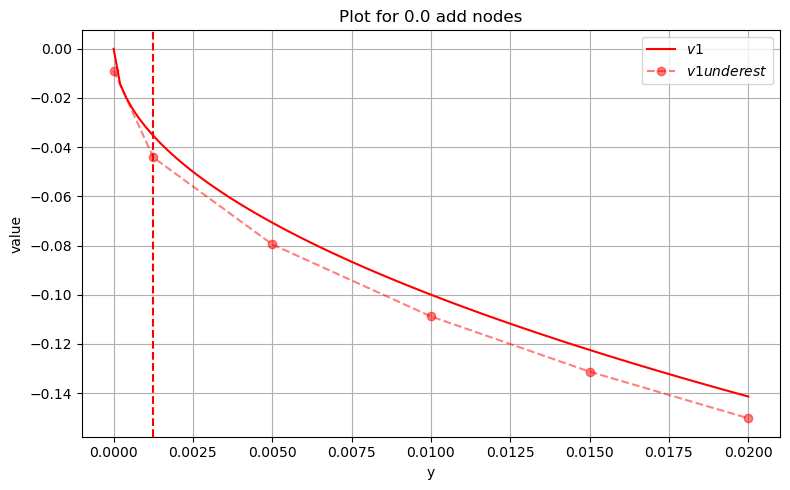

   
   
   
effective add node num  0
y node is  [0.        0.0003125 0.00125   0.005     0.01      0.015     0.02     ]
y node length 7
ms value is  [-0.00441947289798822, -1.4258516468218518e-08]
new_nodes is  0.0003125000000000001
this time choose scenario  0


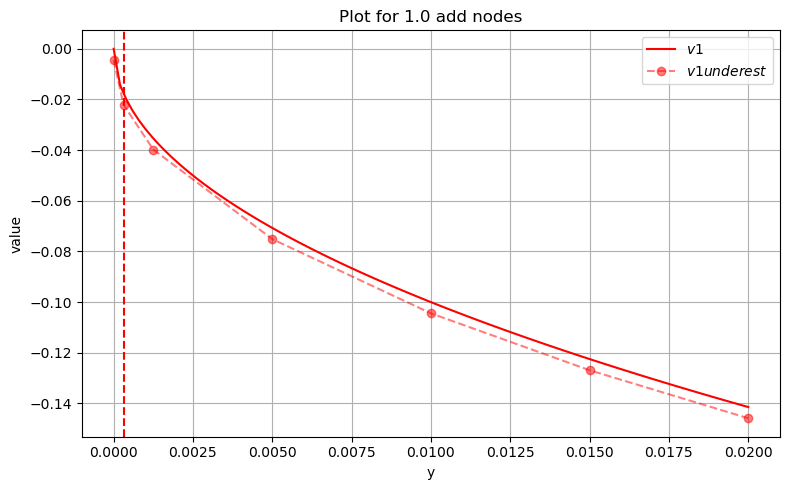

   
   
   
effective add node num  0
y node is  [0.0000e+00 7.8125e-05 3.1250e-04 1.2500e-03 5.0000e-03 1.0000e-02
 1.5000e-02 2.0000e-02]
y node length 8
ms value is  [-0.0029463104541476125, -2.9771061489311523e-08]
new_nodes is  7.812500000000003e-05
this time choose scenario  0


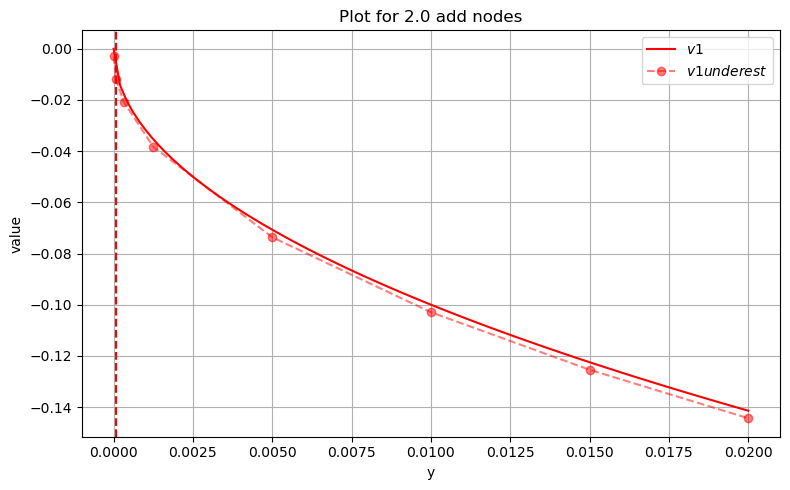

   
   
   
effective add node num  0
y node is  [0.00000000e+00 7.81250000e-05 3.12500000e-04 1.25000000e-03
 2.81516692e-03 5.00000000e-03 1.00000000e-02 1.50000000e-02
 2.00000000e-02]
y node length 9
ms value is  [-0.0022098770167209496, -2.999265325334677e-08]
new_nodes is  0.0028151669229863523
this time choose scenario  0


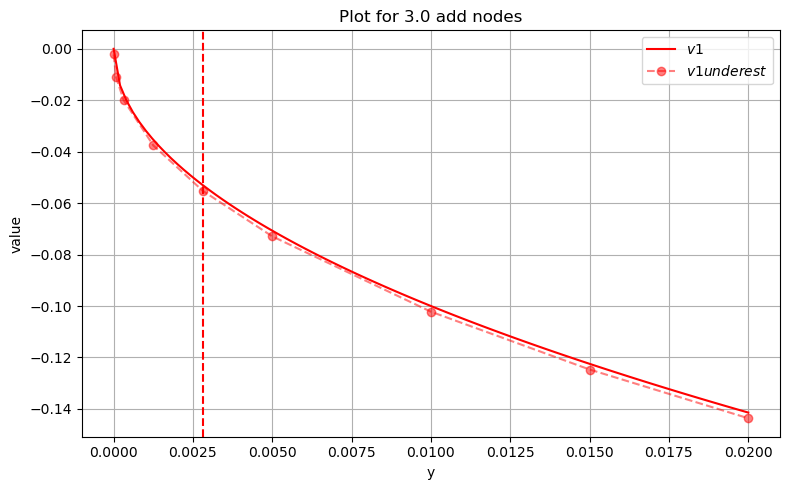

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.94543606e-05 7.81250000e-05 3.12500000e-04
 1.25000000e-03 2.81516692e-03 5.00000000e-03 1.00000000e-02
 1.50000000e-02 2.00000000e-02]
y node length 10
ms value is  [-0.001473187515344504, -5.905211829942969e-09]
new_nodes is  1.945436059885308e-05
this time choose scenario  0


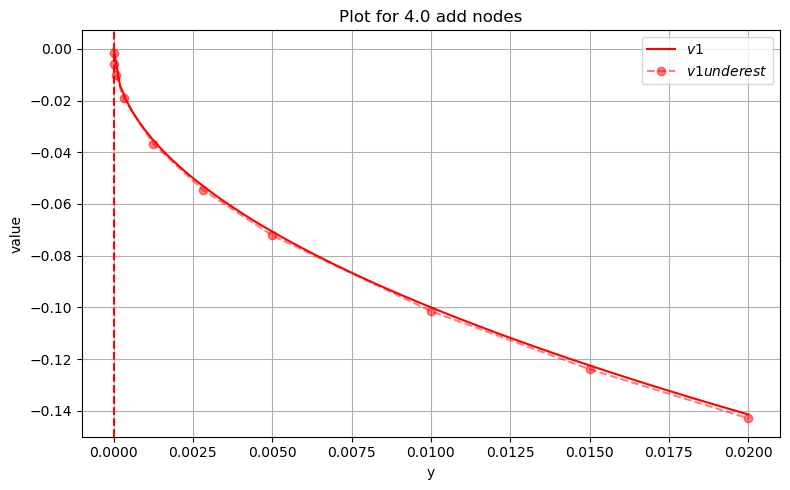

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.94543606e-05 7.81250000e-05 3.12500000e-04
 7.04011247e-04 1.25000000e-03 2.81516692e-03 5.00000000e-03
 1.00000000e-02 1.50000000e-02 2.00000000e-02]
y node length 11
ms value is  [-0.0012563134617026295, -9.399826549072454e-09]
new_nodes is  0.0007040112473734813
this time choose scenario  0


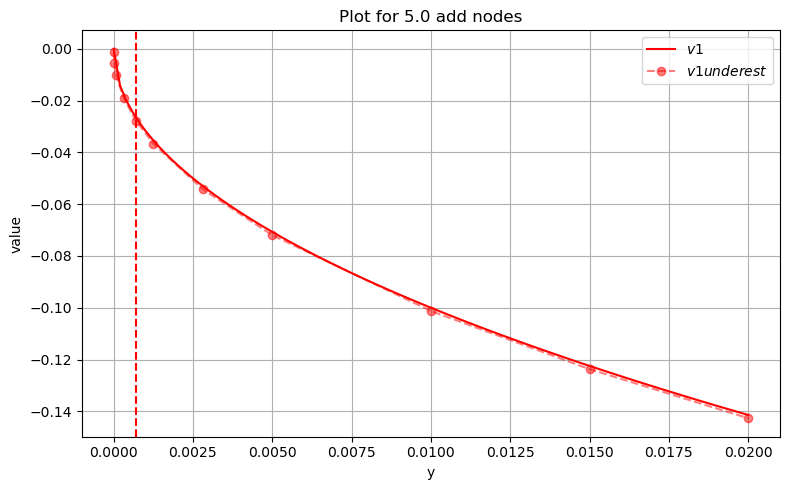

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.94543606e-05 7.81250000e-05 3.12500000e-04
 7.04011247e-04 1.25000000e-03 2.81516692e-03 5.00000000e-03
 7.28143508e-03 1.00000000e-02 1.50000000e-02 2.00000000e-02]
y node length 12
ms value is  [-0.0011028120442479, -6.795152635019619e-09]
new_nodes is  0.007281435078237826
this time choose scenario  0


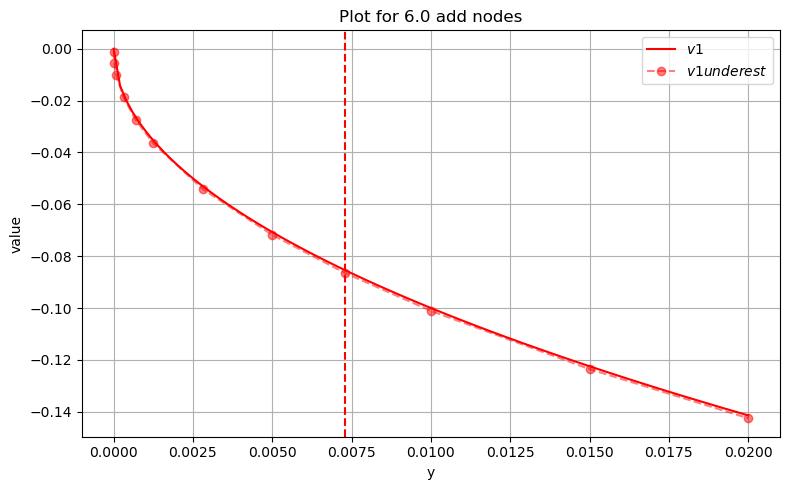

   
   
   
effective add node num  0
y node is  [0.00000000e+00 4.90099354e-06 1.94543606e-05 7.81250000e-05
 3.12500000e-04 7.04011247e-04 1.25000000e-03 2.81516692e-03
 5.00000000e-03 7.28143508e-03 1.00000000e-02 1.50000000e-02
 2.00000000e-02]
y node length 13
ms value is  [-0.0008862079095065742, -1.3414945724187985e-07]
new_nodes is  4.90099354225633e-06
this time choose scenario  0


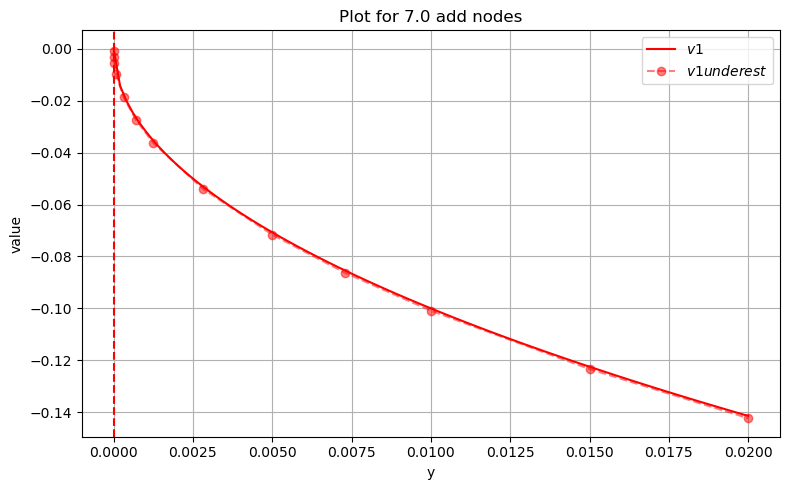

   
   
   
effective add node num  0
y node is  [0.00000000e+00 4.90099354e-06 1.94543606e-05 7.81250000e-05
 3.12500000e-04 7.04011247e-04 1.25000000e-03 1.95423611e-03
 2.81516692e-03 5.00000000e-03 7.28143508e-03 1.00000000e-02
 1.50000000e-02 2.00000000e-02]
y node length 14
ms value is  [-0.0007365752350740684, -1.3500217784434207e-07]
new_nodes is  0.0019542361125908605
this time choose scenario  0


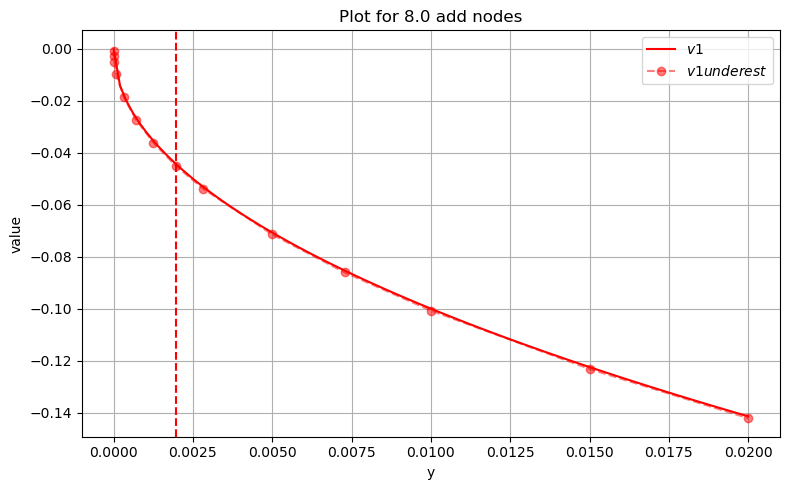

In [17]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.00883885315581196, 0.004419487156504688, 0.002946340225209102, 0.002209907009374203, 0.001473193420556334, 0.0012563228615291785, 0.001102818839400535, 0.0008863420589638161, 0.0007367102372519128, 0.0006296646400794784, 0.0005678028104564676, 0.0005539319839785389, 0.0004435958536974688, 0.0003701720470681944, 0.0003426144583036821, 0.00034028968255421206, 0.00031460871601337193, 0.00029046030078561515, 0.00027523069320949356, 0.0002463643321339177, 0.00022244801935592104, 0.00020153955603004333, 0.00018242746101486277, 0.00017001224986016997, 0.00015717370878575614, 0.00015000256791393397, 0.000147267897448658, 0.00014070120745973415, 0.00013565985320017771, 0.00012458693377749477, 0.00011153331529921288, 0.00010076935275569316, 9.49676539033046e-05, 9.12567094830615e-05, 8.919539797849595e-05, 8.511554503394509e-05, 8.302871480130595e-05, 8.21771652420709e-05, 8.027077306729726e-05, 7.613345743309551e-05, 7.495728186017373e-05, 7.410153359426418e-05, 7.122982974758771e-05, 6.5642

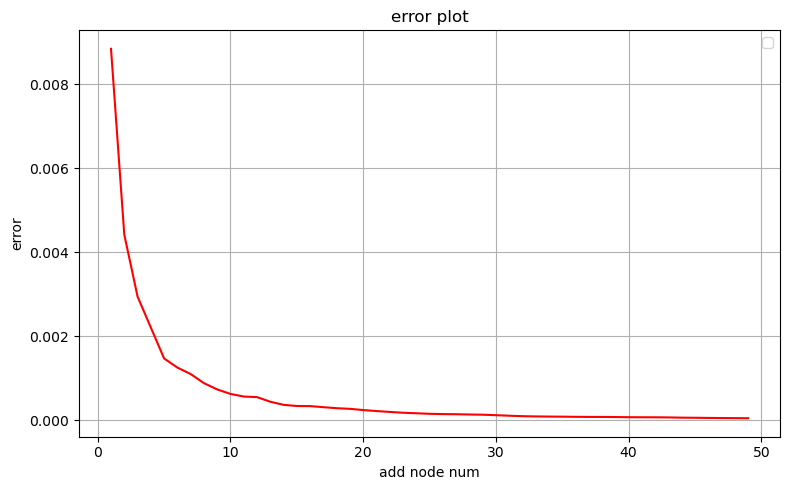

In [23]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [71]:
errors

[0.05261493353885349,
 0.02466310269684402,
 0.010686826841646235,
 0.006028247444075374,
 0.0036989896053867266,
 0.0013698308624792155,
 0.0006840984333196243,
 0.003495651564627167,
 0.0027903822760619867,
 0.002327273459130863,
 0.001996803133321068,
 0.0017929039039972228,
 0.0017485693658303436,
 0.001394714262227481,
 0.001159715011047835]

In [46]:
m = ConcreteModel()
m.y = Var(bounds=(0, 1))
m.x1 = Var(bounds=(0, 1))
m.x11 = Var(bounds=(0, None))
m.x2 = Var()
m.c1 = Constraint(expr=m.x11**2 == m.y**2)
m.c2 = Constraint(expr=m.x11 == (m.x1)**2)
m.c3 = Constraint(expr=m.x2 == -(m.y-1)**2)
m.obj = Objective(expr=-m.x1+m.x2, sense=minimize)

In [47]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [48]:
results = solver.solve(m)
mmm = results.problem.lower_bound

In [5]:
mmm = 0